<br>

**Herein**, a varying intercept & varying gradient stochastic regression model wherein the dependent variables are modelled as covarying series.

<br>

# Preliminaries

Cleaning-up

In [1]:
!rm -rf *.sh

<br>

**Packages**

In [2]:
import subprocess

In [3]:
if 'google.colab' in str(get_ipython()):
    subprocess.run('wget -q https://raw.githubusercontent.com/plausibilities/sars/develop/scripts.sh', shell=True)
    subprocess.run('chmod u+x scripts.sh', shell=True)
    subprocess.run('./scripts.sh', shell=True)

<br>

**Paths**

In [4]:
import os
import pathlib
import sys

In [5]:
if not 'google.colab' in str(get_ipython()):
    
    notebooks = os.path.split(os.getcwd())[0]
    parent = str(pathlib.Path(notebooks).parent)
    sys.path.append(parent)


In [6]:
warehouse = 'capita'

if not os.path.exists(warehouse):
    os.makedirs(warehouse)

<br>

**Libraries**

In [7]:
%matplotlib inline

In [8]:
import arviz as az
import graphviz
import pymc3 as pm

import logging
import collections

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import theano


<br>

Custom

In [9]:
import sars.graphics.settings
import sars.graphics.relational

<br>

**Generic Instances**

In [10]:
relational = sars.graphics.relational.Relational()

RelationalGraphLabels = collections.namedtuple(typename='RelationalGraphLabels',
                                               field_names=['title', 'xlabel', 'ylabel'])

<br>

## Set-up

**Display**<br>
If the display screen supports **retina display**, a figure's resolution can be enhanced via


In [11]:
%config InlineBackend.figure_format = 'retina'

<br>

**Jupyter Settings**

In [12]:
settings = sars.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

## Logging

In [13]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

<br>
<br>

# Data

## Baseline

In [14]:
import sars.models.inpatients.src.baseline

In [15]:
baseline = sars.models.inpatients.src.baseline.Baseline().exc()

In [16]:
baseline.rename(columns={"datetimeobject": "date"}, inplace=True)

In [17]:
logger.info('\n{}\n'.format(baseline.tail()))

INFO:__main__:
            date STUSPS  deathCumulative  positiveCumulative  \
13389 2021-01-13     WY            522.0             48289.0   
13390 2021-01-14     WY            522.0             48701.0   
13391 2021-01-15     WY            522.0             48909.0   
13392 2021-01-16     WY            522.0             49068.0   
13393 2021-01-17     WY            522.0             49363.0   

       hospitalizedCumulative  deathRate  positiveRate  hospitalizedRate  \
13389                  1197.0  90.192982   8343.541958        206.821838   
13390                  1207.0  90.192982   8414.728756        208.549673   
13391                  1211.0  90.192982   8450.667722        209.240807   
13392                  1215.0  90.192982   8478.140297        209.931941   
13393                  1223.0  90.192982   8529.111426        211.314209   

       ndays  
13389    357  
13390    358  
13391    359  
13392    360  
13393    361  



In [18]:
logger.info(baseline.info())

INFO:__main__:None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13394 entries, 0 to 13393
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    13394 non-null  datetime64[ns]
 1   STUSPS                  13394 non-null  object        
 2   deathCumulative         13394 non-null  float64       
 3   positiveCumulative      13394 non-null  float64       
 4   hospitalizedCumulative  13394 non-null  float64       
 5   deathRate               13394 non-null  float64       
 6   positiveRate            13394 non-null  float64       
 7   hospitalizedRate        13394 non-null  float64       
 8   ndays                   13394 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 941.9+ KB


<br>
<br>

## Focus

In [19]:
Futures = collections.namedtuple(typename='Futures', field_names=['steps', 'ahead'])
futures = Futures._make([np.array([1]), 21])

In [20]:
Variables = collections.namedtuple(typename='Variables', field_names=['independent', 'dependent', 'label', 'independent_'])
variables = Variables._make((['ndays'], ['positiveRate', 'hospitalizedRate', 'deathRate'], 
                             ['positive/100K [C]', 'hospitalized/100K [C]', 'death/100K [C]'], 'date'))

<br>

**State**

In [21]:
stusps = 'ND'

<br>

**Data**

* N: The number of records
* M: The number of independent variables
* P: The number of dependent variables

In [22]:
import sars.models.inpatients.src.focus

In [23]:
data, parameters = sars.models.inpatients.src.focus.Focus(
    baseline=baseline, variables=variables, futures=futures).exc(stusps=stusps)

logger.info('The fields of data\n{}\n'.format(data._fields))
logger.info('The fields of parameters\n{}\n'.format(parameters._fields))

INFO:__main__:The fields of data
('abscissae', 'independent', 'dependent', 'abscissae_', 'independent_')

INFO:__main__:The fields of parameters
('N', 'M', 'P')



<br>
<br>

**Illustration**

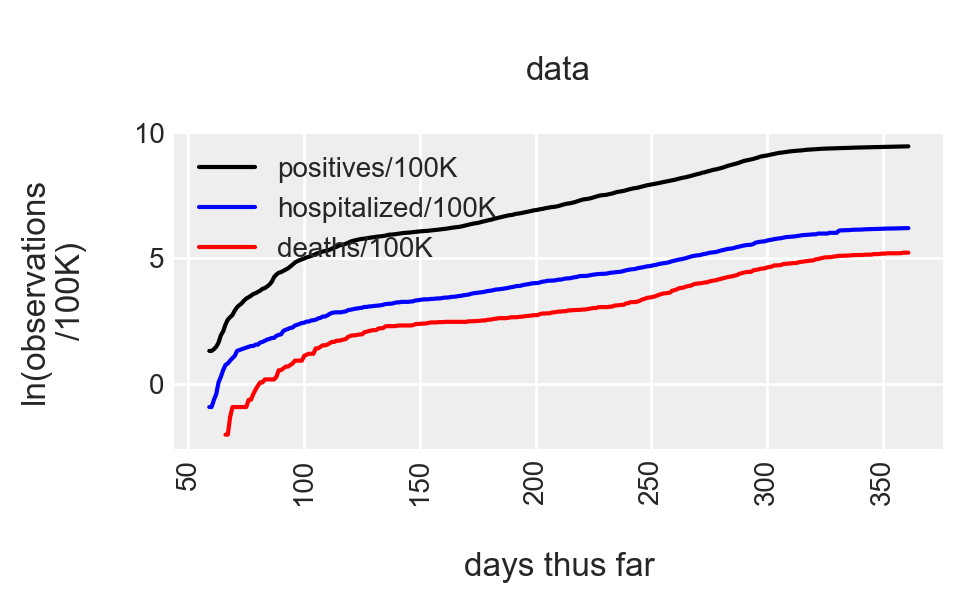

In [24]:
ax = relational.figure(width=4.7, height=2.9)
ax.set_prop_cycle(color=['black', 'blue', 'red'])

ax.plot(data.independent, np.log(data.dependent), '-')

ax.tick_params(axis='x', labelrotation=90)
relational.annotation(handle=ax, 
                      labels=RelationalGraphLabels._make(['\ndata\n', '\ndays thus far', 'ln(observations\n/100K)\n']))

ax.legend(labels=['positives/100K', 'hospitalized/100K', 'deaths/100K'], loc='upper left', fontsize='small');                      

<br>
<br>

# Inference

## Scaled Tensors

In [25]:
import sars.models.inpatients.scaled

In [26]:
scaled = sars.models.inpatients.scaled.Scaled(data=data).exc()

logger.info('scaled\n{}\n'.format(scaled._fields))

INFO:__main__:scaled
('xscale', 'independent', 'abscissae', 'yscale', 'dependent')



<br>

## Elements

In [27]:
import sars.models.inpatients.elements

In [28]:
sections_ = scaled.independent.shape[0]
instances_ = np.ones(shape=scaled.independent.shape[0], dtype=int)

elements = sars.models.inpatients.elements.Elements(sections_=sections_, instances_=instances_).exc()

logger.info('elements\n{}\n'.format(elements._fields))

INFO:__main__:elements
('sections_', 'instances_', 'indices')



<br>
<br>

## Model

<br>

**Inference**

In [29]:
import sars.models.inpatients.capita.inference

In [30]:
inference = sars.models.inpatients.capita.inference.Inference(data=scaled, parameters=parameters, elements=elements)

<br>

Inference Model Characteristics

In [31]:
imc = inference.exc()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, gradient, packed_l_m, intercept, packed_l_c]
INFO:pymc3:NUTS: [sigma, gradient, packed_l_m, intercept, packed_l_c]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 2533 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 2533 seconds.
There were 338 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 338 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.44727234866314264, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The samp

In [32]:
imc._fields

('model', 'trace', 'maximal', 'arviztrace', 'likelihood')

<br>

**DAG**

* http://www.graphviz.org/doc/info/attrs.html

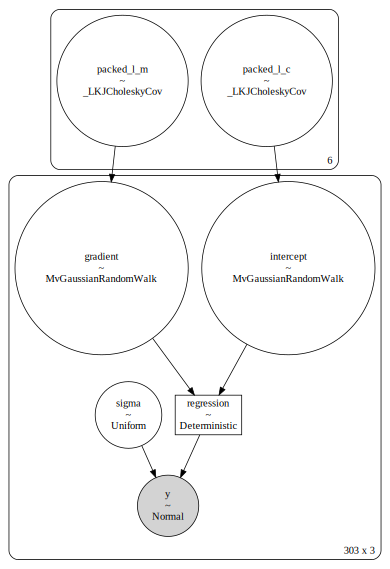

In [33]:
# The DAG
diagram = pm.model_graph.ModelGraph(model=imc.model).make_graph()
diagram.node_attr.update(shape='circle')
diagram.graph_attr.update(size="5.7,7.9")

# Diagrams
diagram.save(os.path.join(warehouse, 'model.gv'))
graphviz.render(engine='dot', format='pdf', filepath=os.path.join(warehouse, 'model.gv'))

graphviz.Source.from_file(filename=os.path.join(warehouse, 'model.gv'))

<br>

**Trace**

In [34]:
imc.trace.varnames

['packed_l_c_cholesky-cov-packed__',
 'intercept',
 'packed_l_m_cholesky-cov-packed__',
 'gradient',
 'sigma_interval__',
 'packed_l_c',
 'packed_l_m',
 'regression',
 'sigma']

<br>

Samplings

In [35]:
samplings = imc.trace.report.n_draws * imc.trace.nchains
logger.info('The number of sampled instances\n{}\n'.format(samplings))

INFO:__main__:The number of sampled instances
1000



<br>
<br>

# Analysis

## Estimates

In [36]:
import sars.models.inpatients.estimates

In [37]:
estimates = sars.models.inpatients.estimates.Estimates(
    trace=imc.trace, futures=futures, samplings=samplings, parameters=parameters)

<br>

**Intercepts & Gradients**

In [38]:
Arguments = collections.namedtuple(typename='Arguments', field_names=['name', 'cholesky'])

intercepts = estimates.exc(arguments=Arguments._make(('intercept', 'packed_l_c')))
gradients = estimates.exc(arguments=Arguments._make(('gradient', 'packed_l_m')))

logger.info('\n{}\n'.format(intercepts.shape))
logger.info('\n{}\n'.format(gradients.shape))

INFO:__main__:
(1000, 324, 3)

INFO:__main__:
(1000, 324, 3)



In [39]:
InterceptsAndGradients = collections.namedtuple(typename='InterceptsAndGradients', field_names=['intercepts', 'gradients'])
iag = InterceptsAndGradients._make([intercepts, gradients])

<br>
<br>

## Predictions

In [40]:
import sars.models.inpatients.predictions

In [41]:
predictions = sars.models.inpatients.predictions.Predictions(
    iag=iag, samplings=samplings, scaled=scaled, parameters=parameters).exc(size=100)

In [42]:
logger.info('\n{}\n'.format(predictions._fields))

INFO:__main__:
('line', 'lines')



In [43]:
logger.info('\n{}\n'.format(predictions.line.shape))
logger.info('\n{}\n'.format(predictions.lines.shape))

INFO:__main__:
(324, 3)

INFO:__main__:
(100, 324, 3)



<br>
<br>

# Illustrate

In [44]:
import sars.models.inpatients.graphs

In [45]:
Fields = collections.namedtuple(typename='Futures', field_names=['initial', 'extended'])
fields = Fields._make((data.independent, data.abscissae))

In [46]:
graphs = sars.models.inpatients.graphs.Graphs(data=data, predictions=predictions, titles=variables.label, fields=fields)

<br>

**Together**

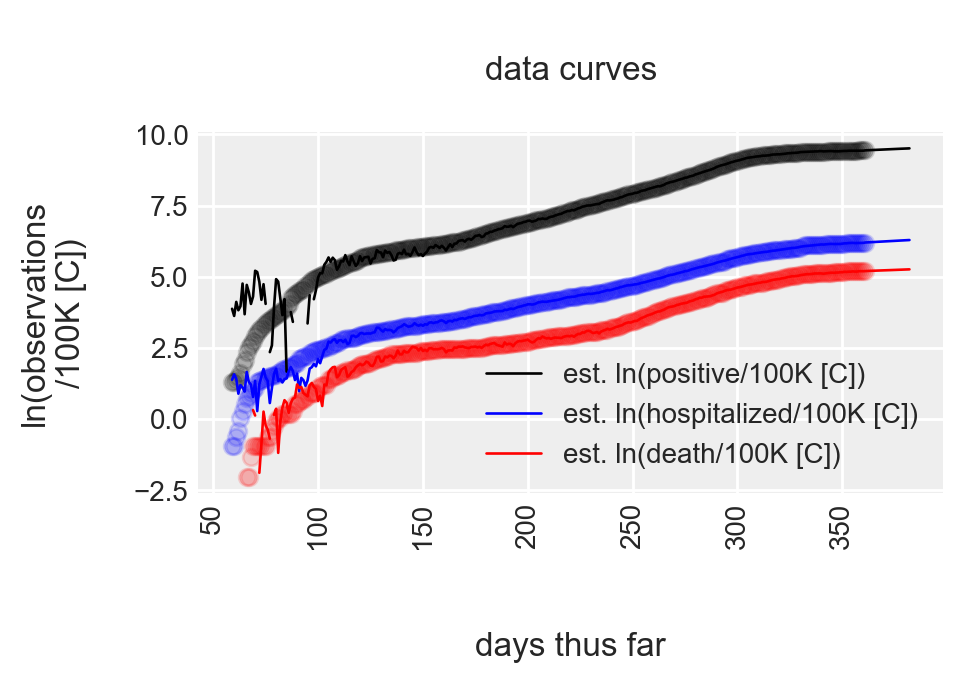

In [47]:
graphs.together(ylabel='ln(observations\n/100K [C])', xlabel='\ndays thus far')

<br>

**Separate**

In [48]:
matplotlib.rcParams['figure.autolayout'] = False
matplotlib.rcParams['figure.constrained_layout.use'] = False
matplotlib.rcParams['figure.figsize'] = 7.1, 5.3

matplotlib.rcParams['savefig.bbox'] = 'standard'
matplotlib.rcParams["savefig.pad_inches"] = 0.5

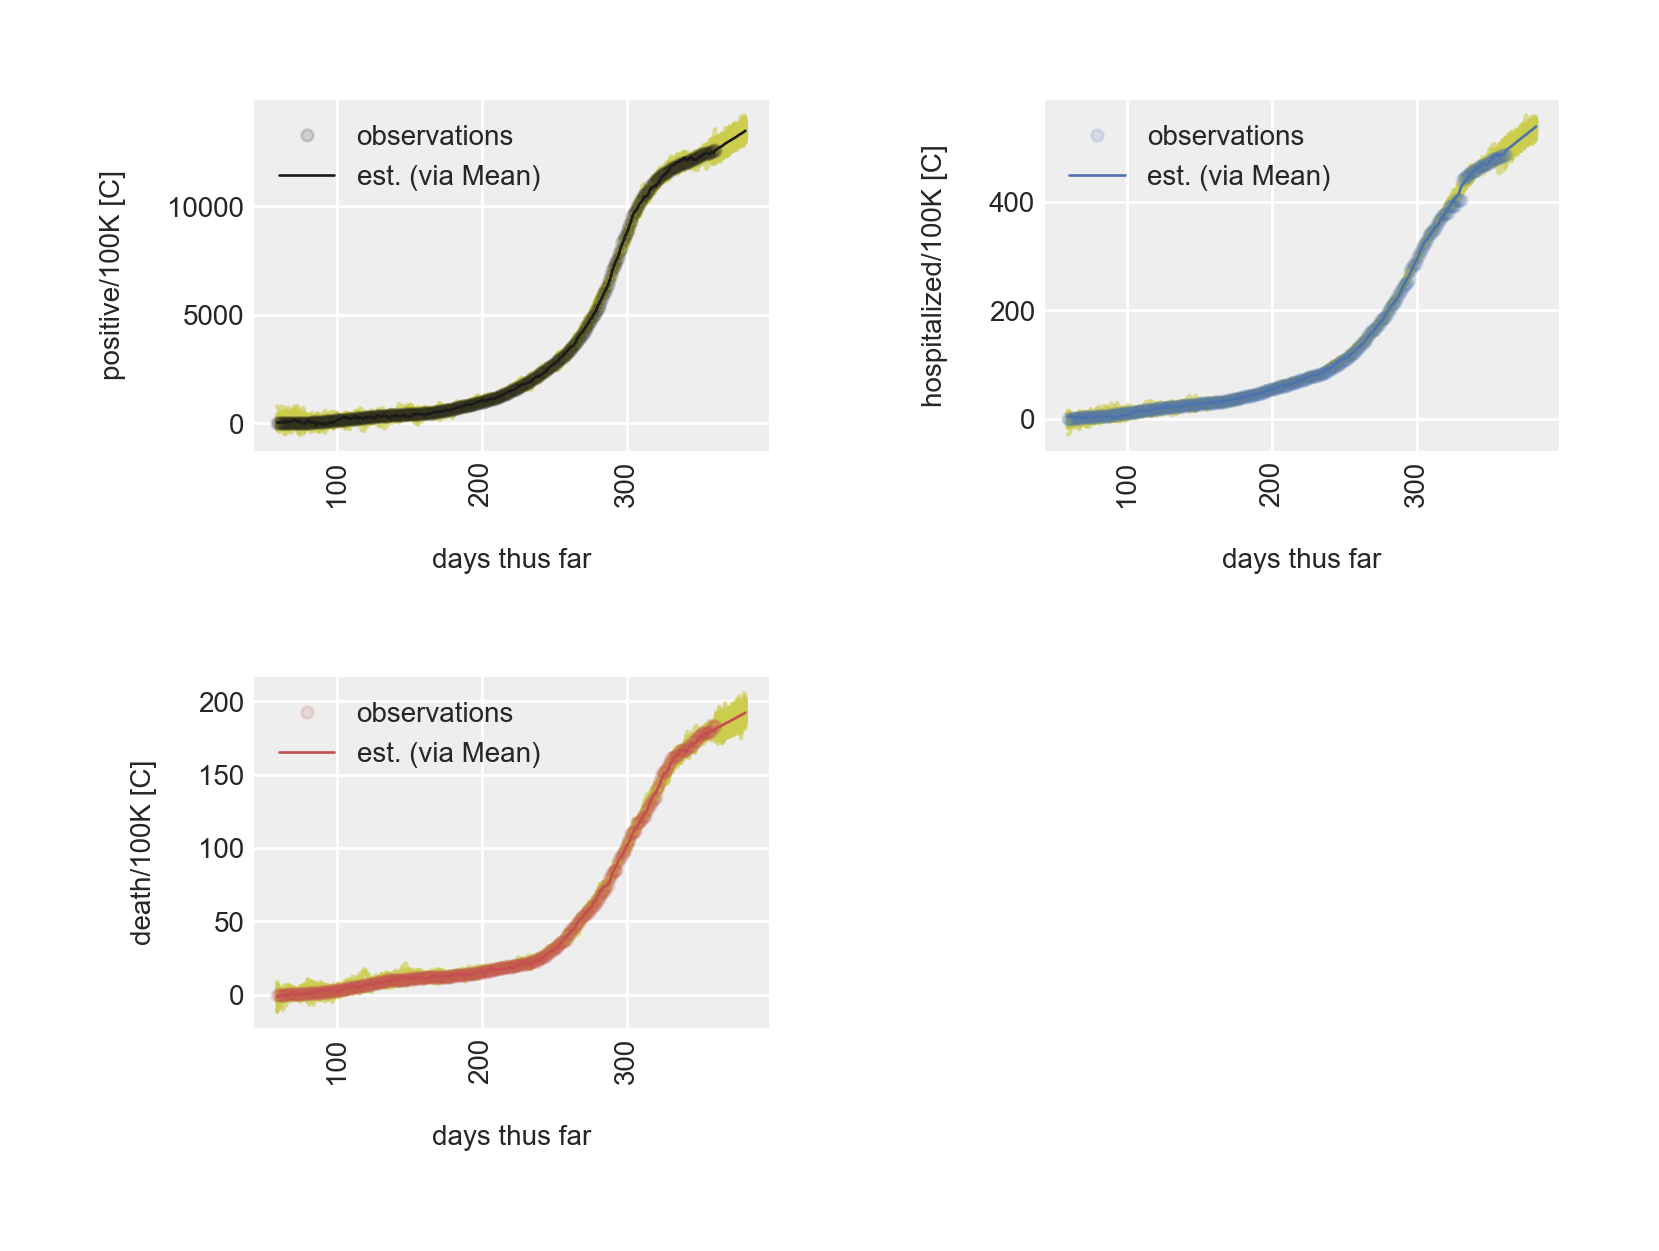

In [49]:
fig, handle = graphs.separate(adjust=np.array([5, 5]), layout=np.array([5, 7]), xlabel='days thus far')

In [50]:
fig.savefig(os.path.join(warehouse, 'capita.png'), transparent=False, 
            pad_inches=0.75,
            bbox_inches=matplotlib.transforms.Bbox([[0, 0], [9.5, 5.5]]).expanded(sw=1.1, sh=1.0))